# Improving Classfication performance on STEAD dataset

In [1]:
from EQDataset import EQDataset
from NoiseDataset import NoiseDataset
import numpy as np
import torch 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import ConcatDataset, DataLoader, random_split
import pandas as pd
import h5py

from obspy.clients.fdsn import Client

from obspy import UTCDateTime

import seisbench.models as sbm

from phasenet import PhaseNet


In [2]:
csv_file_eq = '..//data//chunk5.csv'
file_name_eq = '..//data//chunk5.hdf5'

csv_file_noise = '..//data//chunk1.csv'
file_name_noise = '..//data//chunk1.hdf5'

Structure of the dataset: \
We want earthquakes and noise waves to appear in the same dataset, this shouldnt be separated

In [30]:
batch_size = 256

In [32]:
#cl = 136
#eq_dataset = EQDataset(csv_file_eq, file_name_eq, tri_width=10, transform=True, cutting_length=cl)
#noise_dataset = NoiseDataset(csv_file_noise, file_name_noise, transform=True, cutting_length=cl)

#datasets = [eq_dataset, noise_dataset]

#dataset = ConcatDataset(datasets)

#train_dataset, val_dataset, test_dataset = random_split(dataset, [0.7,0.15, 0.15])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=10)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=10)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

5min 2500
1min 610 (3050)
8 workers 1min (with 10sec init) 1390
10 workers 1min (with 10sec init) 1450

In [8]:
pn_model_standard = PhaseNet()
for i, sample in enumerate(train_dataloader):
    print(sample[0].shape)
    waveform, labels = sample
    res = pn_model_standard(waveform.unsqueeze(1))
    break

torch.Size([64, 5864])


In [28]:
pt_model = sbm.PhaseNet.from_pretrained("stead")
#layer_stead = nn.Conv1d(1, 8, 7, padding='same', stride=(1,))
#layer_stead.weight.data = pn_model.inc.weight.data[:,0,:].unsqueeze(1)
#pn_model.inc = layer_stead 
#pn_model.in_channels = 1

In [5]:
pn_model = PhaseNet()
pn_model

PhaseNet(
  (inc): Conv1d(1, 8, kernel_size=(7,), stride=(1,), padding=same)
  (in_bn): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (down_branch): ModuleList(
    (0): ModuleList(
      (0): Conv1d(8, 8, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(8, 8, kernel_size=(7,), stride=(4,), padding=(3,), bias=False)
      (3): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ModuleList(
      (0): Conv1d(8, 16, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(16, 16, kernel_size=(7,), stride=(4,), bias=False)
      (3): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ModuleList(
      (0): Conv1d(16, 32, kernel_size=(7,), stride=(1,

In [6]:
for i, sample in enumerate(train_dataloader):
    print(sample[0].shape)
    waveform, labels = sample
    res = pn_model(waveform.unsqueeze(1))
    break

torch.Size([64, 5900])
1 torch.Size([64, 8, 5900])
2 torch.Size([64, 8, 5900])
3 torch.Size([64, 16, 1475])
4 torch.Size([64, 32, 369])
5 torch.Size([64, 64, 92])
6 torch.Size([64, 128, 23])
first for loop done
0 torch.Size([64, 128, 23])
torch.Size([64, 64, 92])
torch.Size([64, 128, 92])
1 torch.Size([64, 64, 92])
torch.Size([64, 32, 368])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 369 but got size 1 for tensor number 1 in the list.

In [35]:
# Initialize default parameters
epochs = 10
learning_rate = 3e-2

# Initialize datasets and dataloaders
train_loader = train_dataloader

# Initialize the model and optimizer
#device = torch.device("mps")
#model = PhaseNet()
#model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#criterion = torch.nn.CrossEntropyLoss(reduction = 'sum')  # Replace with your loss function

In [39]:
# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device).unsqueeze(1), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs, logits=True)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.cpu().detach().numpy() / inputs.shape[0]
        if (not i%250):
            print(i, train_loss) 
            
    print(f"End of Epoch Training loss {train_loss / len(train_dataloader)}")
            
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device).unsqueeze(1), labels.to(device)
            outputs = model(inputs, logits=True)
            val_loss += criterion(outputs, labels) / inputs.shape[0]
        
        print(f'Validation loss for epoch {epoch}: ', val_loss / len(val_dataloader))
        

0 21.81033706665039
250 5747.460618972778
500 11414.155405044556
750 17094.716276168823
1000 22713.044439315796
End of Epoch Training loss 22.66966347748056
Validation loss for epoch 0:  tensor(22.8049, device='mps:0')
0 22.496658325195312
250 5667.336124420166
500 11324.217086791992
750 17011.650909423828
1000 22681.654596328735
End of Epoch Training loss 22.61440317711433
Validation loss for epoch 1:  tensor(22.8196, device='mps:0')
0 23.89289665222168
250 5676.729286193848
500 11292.622751235962
750 16926.218030929565
1000 22600.675247192383
End of Epoch Training loss 22.578281860154554
Validation loss for epoch 2:  tensor(22.7732, device='mps:0')
0 26.819114685058594
250 5642.955743789673
500 11299.306022644043
750 16904.65182685852
1000 22583.45009613037
End of Epoch Training loss 22.54862902144806
Validation loss for epoch 3:  tensor(22.7809, device='mps:0')
0 25.748136520385742
250 5659.235048294067
500 11334.574174880981
750 16972.178331375122
1000 22561.11454963684
End of Epoc

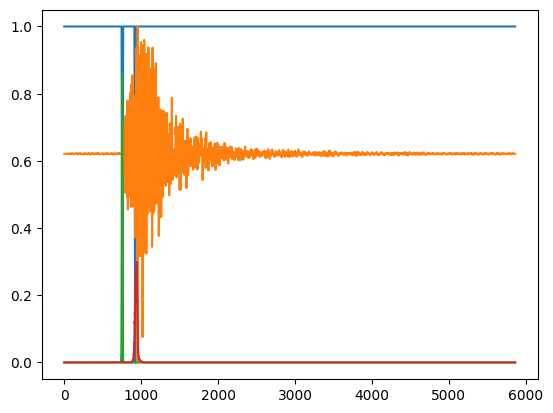

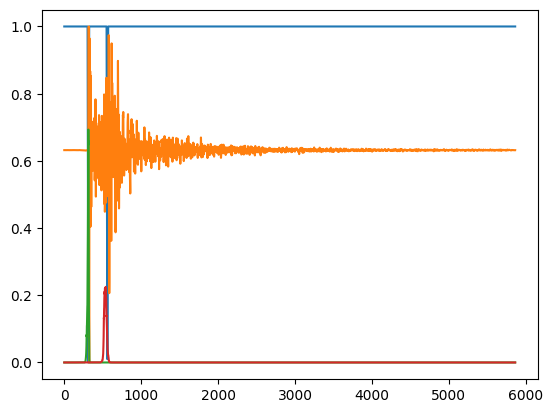

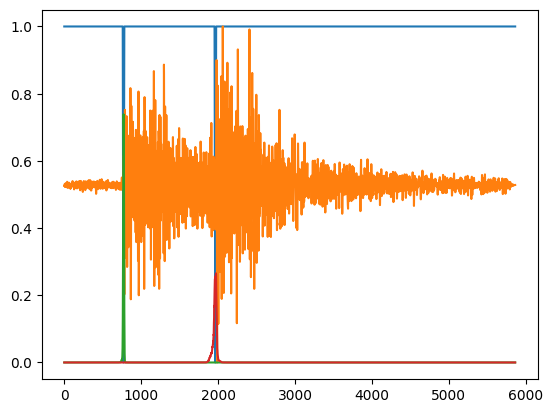

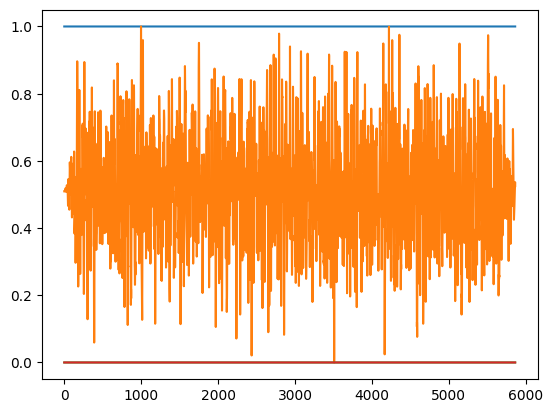

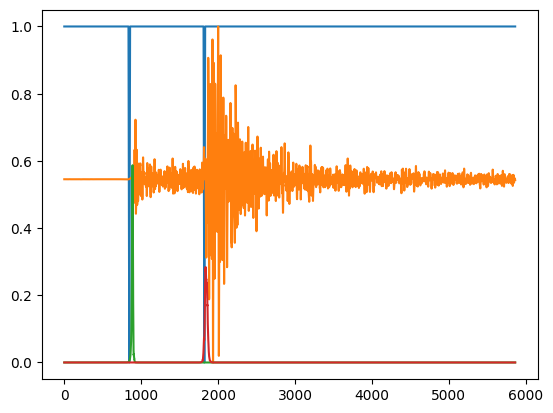

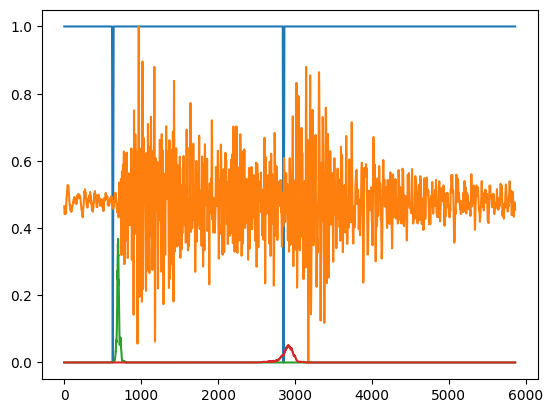

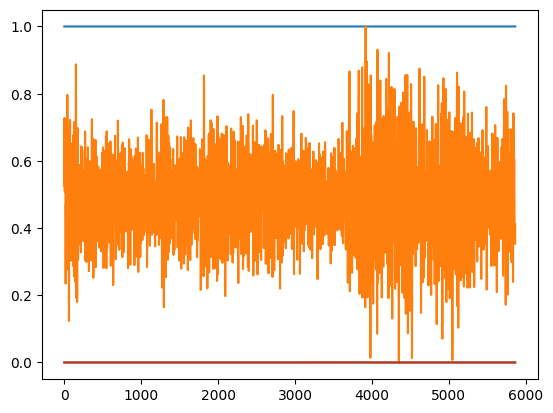

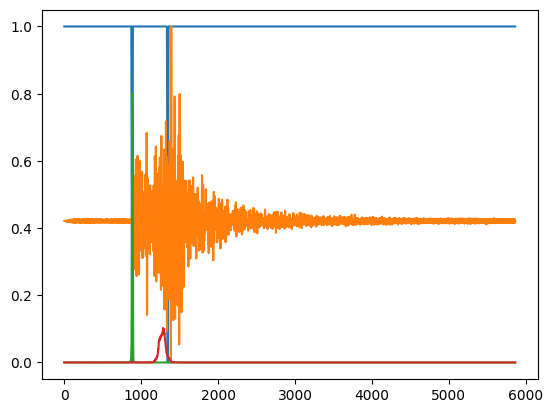

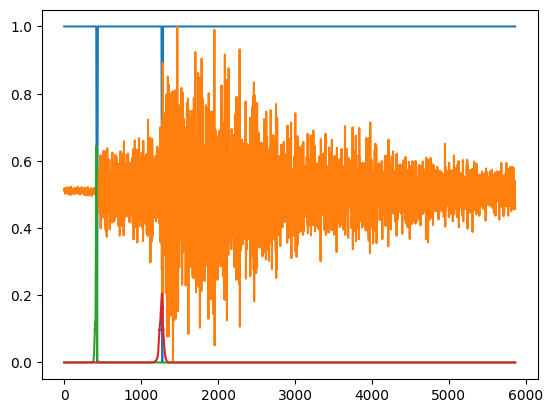

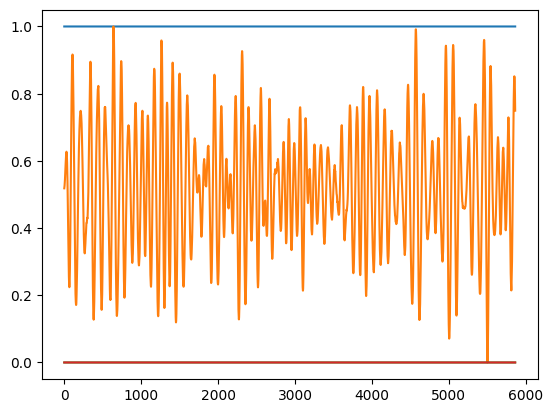

In [38]:
val_loss = 0
batch_num = 2
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_dataloader):
        if (i > 0):
            inputs, labels = inputs.to(device).unsqueeze(1), labels.to(device)
            outputs = model(inputs)
            plt.plot(labels.cpu().detach().numpy()[batch_num, 2, :])
            plt.plot(inputs.cpu().detach().numpy()[batch_num, 0, :])
            plt.plot(outputs.cpu().detach().numpy()[batch_num,0,:])
            plt.plot(outputs.cpu().detach().numpy()[batch_num,1,:])
            #val_loss += criterion(outputs, labels) / inputs.shape[0]
            plt.show()
            if (i == 10): break
    
    #print(f'Validation loss for epoch {0}: ', val_loss / len(val_dataloader))

In [29]:
val_loss = 0
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs
        outputs = pt_model(inputs)
        plt.plot(inputs.detach().numpy()[0, 0, :])
        plt.plot(outputs.detach().numpy()[0,0,:])
        plt.plot(outputs.detach().numpy()[0,1,:])
        #val_loss += criterion(outputs, labels) / inputs.shape[0]
        
        break

RuntimeError: Given groups=1, weight of size [8, 3, 7], expected input[64, 1, 6000] to have 3 channels, but got 1 channels instead